In [61]:
!pip install pandas scikit-learn matplotlib numpy

1289.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

In [63]:
#Load NBA dataset -> (2004-2018)
df = pd.read_csv("../data/games.csv")

print("(Games from 2004-2018, Stat/Attribute):", df.shape) 

print("\n--------------------------- Display First 5 Rows ---------------------------")
print(df.head())

print("\n-------------------------------- Column Names --------------------------------")
print(df.columns)

print("\n-------------------------- Missing Values Per Column --------------------------")
print(df.isnull().sum().head(21)) 

(Games from 2004-2018, Stat/Attribute): (26651, 21)

--------------------------- Display First 5 Rows ---------------------------
  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2022    1610612740     126.0        0.484        0.926  ...      25.0   
1    2022    1610612762     120.0        0.488        0.952  ...      16.0   
2    2022    1610612739     114.0        0.482        0.786  ...      22.0   
3    2022    1610612755     113.0        0.441        0.909  ...      27.0   
4    2022    1610

In [64]:
#Target Variable: whether home team won (1) or lost (0)
print("\n-------------- Target distribution (1 = Win, 0 = Loss) --------------")
wl = df["HOME_TEAM_WINS"]
print(wl.value_counts())

#Features: subset of stats used to prepare model to predict hometeam wins
print("\n--------------------------- Feature sample ---------------------------")

gstat = df[["PTS_home", "REB_home", "AST_home",
    "FG_PCT_home", "FT_PCT_home", "FG3_PCT_home"
]]
print(gstat.head(6))


-------------- Target distribution (1 = Win, 0 = Loss) --------------
HOME_TEAM_WINS
1    15645
0    11006
Name: count, dtype: int64

--------------------------- Feature sample ---------------------------
   PTS_home  REB_home  AST_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home
0     126.0      46.0      25.0        0.484        0.926         0.382
1     120.0      40.0      16.0        0.488        0.952         0.457
2     114.0      37.0      22.0        0.482        0.786         0.313
3     113.0      49.0      27.0        0.441        0.909         0.297
4     108.0      47.0      22.0        0.429        1.000         0.378
5     112.0      62.0      26.0        0.386        0.840         0.317


In [65]:
imputer = SimpleImputer(strategy="mean") #Creates tool to fill missing values with averages by replacing NaNs in gstat with column names
gstat = imputer.fit_transform(gstat) #fit() calculates avg for each column that are missing values and transform() replaces all NaN values with those avgs

#Converts back to DataFrame after imputation, restoring column names that were lost during imputation
gstat = pd.DataFrame(gstat, columns=[
    "PTS_home", "REB_home", "AST_home",
    "FG_PCT_home", "FT_PCT_home", "FG3_PCT_home"
])

In [66]:
#Split data: 80% training (learn patterns), 20% testing (evaluate on unseen games)
gstat_train, gstat_test, wl_train, wl_test = train_test_split(gstat, wl, test_size=0.2, random_state=42)

print("Training set shape:", gstat_train.shape)
print("Test set shape:", gstat_test.shape)

Training set shape: (21320, 6)
Test set shape: (5331, 6)


In [67]:
#model looks at the stats (points, rebounds, FG%, etc.) and learns how much each one pushes a game toward being a win vs a loss
model = LogisticRegression(max_iter=1000)

#Train model on training set -> learns weights for each stat
model.fit(gstat_train, wl_train) 

#Predict outcomes on unseen test games using its learned weights
wl_pred = model.predict(gstat_test)

#Evaluate performance
acc = accuracy_score(wl_test, wl_pred)
print("Accuracy: {:.2f}%".format(acc*100))
print("\nClassification Report:\n", classification_report(wl_test, wl_pred))

Accuracy: 76.08%

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.66      0.70      2201
           1       0.78      0.83      0.80      3130

    accuracy                           0.76      5331
   macro avg       0.76      0.75      0.75      5331
weighted avg       0.76      0.76      0.76      5331



In [68]:
#Exporting data for Tableau
#Create dataframe called results and will include the 6 Game Stats from the 20% test set
results= gstat_test.copy()
#Inserts the real outcomes
results["Actual"] = wl_test.values
#the model prediction
results["Predicted"] = wl_pred


#Exports the dataframe to a file so tableau can read it
results.to_csv("nba_predictions.csv", index=False)

#Export feature importance
feature_importance = pd.DataFrame({
    "Feature": gstat.columns,
    "Coefficient": model.coef_[0]
})
feature_importance.to_csv("feature_importance.csv", index=False)

#Export win/loss distribution
wl_counts = wl.value_counts().reset_index()
wl_counts.columns = ["Result", "Count"]
wl_counts.to_csv("win_loss_distribution.csv", index=False)

print("CSV files exported successfully.")

CSV files exported successfully.


In [69]:
#accuracy dataset
accuracy_value = pd.DataFrame({
    "Metric": ["Model Accuracy"],
    "Value": [acc * 100]
})

accuracy_value.to_csv("model_accuracy_kpi.csv", index=False)

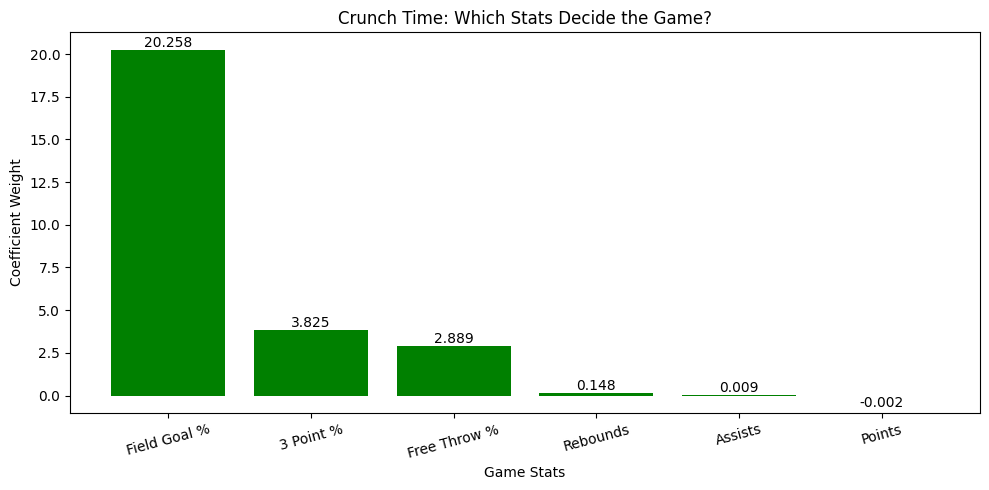

In [70]:
coeffs = model.coef_[0] #Our (model) uses logistic regression to obtain weight for each feature
subfeats = gstat.columns

betterNames = {
    "PTS_home": "Points",
    "REB_home": "Rebounds",
    "AST_home": "Assists",
    "FG_PCT_home": "Field Goal %",
    "FT_PCT_home": "Free Throw %",
    "FG3_PCT_home": "3 Point %"
}
labels = [betterNames[feat] for feat in subfeats]

sorted_pairs = sorted(zip(labels, coeffs), key=lambda x: abs(x[1]), reverse=True)
labels, coeffs = zip(*sorted_pairs)

plt.figure(figsize=(10, 5))
plt.bar(labels, coeffs, color = 'green')

for i, v in enumerate(coeffs):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom" if v > 0 else "top")
    
plt.title("Crunch Time: Which Stats Decide the Game?")
plt.ylabel("Coefficient Weight")
plt.xlabel("Game Stats")
plt.xticks(rotation=15)
plt.tight_layout()

plt.show()

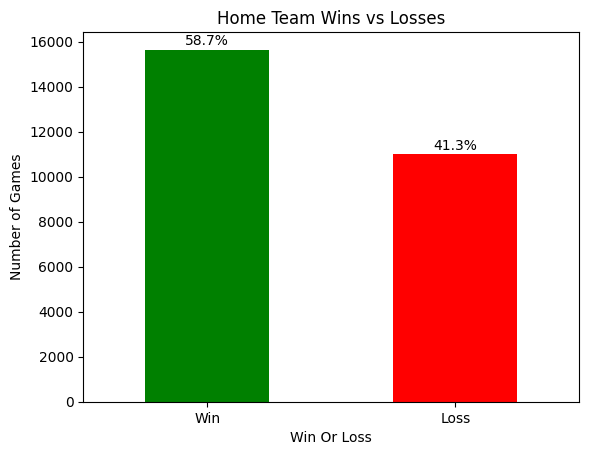

In [71]:
wlAgain = wl.replace({0: "Loss", 1: "Win"})

counts = wlAgain.value_counts()
colors = ["red" if x == "Loss" else "green" for x in counts.index]
#Plot
counts.plot(kind="bar", color=colors, title="Home Team Wins vs Losses")

plt.xlabel("Win Or Loss")
plt.ylabel("Number of Games")
plt.xticks(rotation=0)

#Included percentage labels
for i, v in enumerate(counts):
    pct = v / counts.sum() * 100
    plt.text(i, v + 200, f"{pct:.1f}%", ha="center")
    
plt.show()

In my project I used a logistic regression model to predict whether the home team wins an NBA game based on stats from 2004-2018. The model is ~76% accurate, showing that relatively simple features can still explain a large share of game outcomes.

In terms of feature importance, field goal % had the strongest weight on predicting wins, while assists contributed the least. This makes sense from a basketball context as shot efficiency tends to drive results more directly than playmaking stats. 